In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=4000

# number of (Gaussian) covariates
p=20

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [3]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.0

In [4]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [5]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1
df['y'] = pd.Series(y)

(array([81., 83., 71., 72., 56., 58., 62., 38., 44., 47., 51., 49., 42.,
        36., 48., 38., 40., 48., 35., 32., 46., 35., 29., 40., 39., 31.,
        42., 31., 26., 33., 34., 36., 29., 29., 33., 27., 38., 35., 31.,
        32., 25., 33., 40., 27., 29., 27., 23., 30., 29., 21., 28., 33.,
        46., 27., 27., 28., 28., 26., 27., 32., 32., 34., 29., 32., 30.,
        21., 33., 33., 37., 22., 28., 36., 34., 33., 34., 39., 26., 35.,
        45., 41., 47., 41., 34., 42., 36., 32., 50., 34., 50., 46., 53.,
        40., 51., 62., 57., 53., 81., 86., 77.]),
 array([4.05372654e-04, 1.03994643e-02, 2.03935560e-02, 3.03876476e-02,
        4.03817393e-02, 5.03758310e-02, 6.03699226e-02, 7.03640143e-02,
        8.03581059e-02, 9.03521976e-02, 1.00346289e-01, 1.10340381e-01,
        1.20334473e-01, 1.30328564e-01, 1.40322656e-01, 1.50316748e-01,
        1.60310839e-01, 1.70304931e-01, 1.80299023e-01, 1.90293114e-01,
        2.00287206e-01, 2.10281298e-01, 2.20275389e-01, 2.30269481e-01,
       

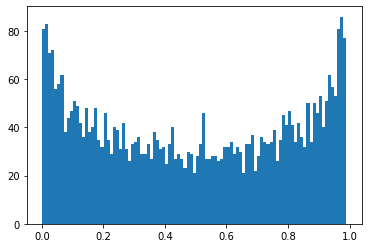

In [6]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([  1.,   0.,   0.,   0.,   0.,   1.,   2.,   5.,   2.,   2.,   2.,
          5.,   4.,   1.,   5.,  12.,   9.,   6.,  11.,  14.,  18.,  26.,
         18.,  20.,  24.,  33.,  38.,  32.,  40.,  47.,  48.,  61.,  43.,
         69.,  71.,  81.,  79.,  91.,  96., 103., 105., 113., 112., 110.,
        131., 124., 110., 116., 131., 110., 121., 106., 113., 107., 100.,
        116., 103.,  83.,  78.,  78.,  72.,  65.,  60.,  57.,  58.,  42.,
         36.,  51.,  36.,  38.,  34.,  16.,  30.,  17.,  13.,  15.,  11.,
         14.,  11.,   8.,   4.,   4.,   2.,   3.,   3.,   0.,   2.,   1.,
          1.,   0.,   3.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,
          1.]),
 array([-7.81029833, -7.64627055, -7.48224277, -7.318215  , -7.15418722,
        -6.99015944, -6.82613166, -6.66210389, -6.49807611, -6.33404833,
        -6.17002055, -6.00599278, -5.841965  , -5.67793722, -5.51390945,
        -5.34988167, -5.18585389, -5.02182611, -4.85779834, -4.69377056,
        -4.52974278, -4.36

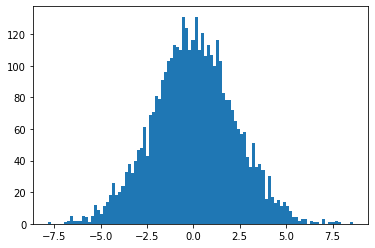

In [7]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [8]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.360841807849882
97.5th percentile: 4.332270174681717


In [9]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.1,0.51,0.01) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE is found to exist at each kappa
kappaProportion = []

d1 = time.time()
# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 5
    
    # nMleExist is the total number of times the MLE was found to exist during each round. This
    # is initially set to 0
    nMleDNE = 0
    for i in range(B):
        #print(i)
        subSample = df.sample(n=sampleSize) # draw the sample
        subSample =subSample.reset_index()
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in whether the model was proved to be infeasible, in which case, the
        # value 3 is returned. In this case we know the MLE exists and is unique.
        print(mleStatus)
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    
    # QUESTION: AREN'T WE INTERESTED IN THE NUMBER OF TIMES MLE DOES NOT EXIST?
    #### Fixed

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE ... 
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp)
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx]
    print(uKappa)
    lKappa = kappaArray[uIdx-1]
else:
    print('Method Failed, All Subsamples are separable!')

d2 = time.time()
delta = round(d2 - d1)
print(kappaProportion, delta)

Using license file C:\Users\jwb22\gurobi.lic
Academic license - for non-commercial use only
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
Method Failed, All Subsamples are separable!
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 6
